In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import scipy.io as sci

from sklearn.model_selection import train_test_split
from functools import partial

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


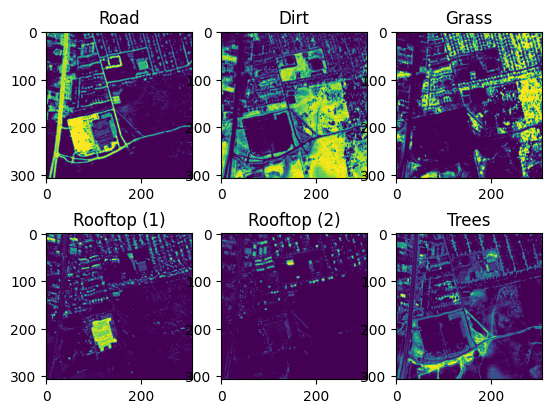

In [7]:
data = sci.loadmat('/content/drive/MyDrive/IMA206/Urban.mat')
X = data['X']
X = X.astype(float) # Please take care that the data matrix must be cast to float in Python, for subsequential operations

gt = sci.loadmat('/content/drive/MyDrive/IMA206/end6_groundTruth.mat')
abundances = gt['A']

nCol = 307
nRow = 307

plt.figure()
#TO DO : try to interpret the abundances that you see. Hint : the 6 sources are usually called ['Grass','Road','Rooftop (2)','Dirt','Trees','Rooftop (1)']. Associate a name to each endmember.
names = ['Road','Dirt','Grass','Rooftop (1)','Rooftop (2)','Trees']
for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    ax.imshow(abundances[ii,:].reshape(nCol,nRow))
    
    plt.title(names[ii])


(<Figure size 640x480 with 1 Axes>,
  <matplotlib.lines.Line2D at 0x7f8bde8d7ac0>])

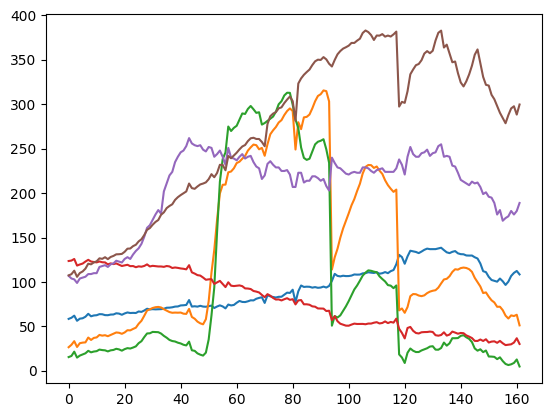

In [8]:
endmembers= np.zeros((162,6))

for ii in range(6): 
    ind = np.where(abundances[ii] > 0.999)[0]
    allPP = X[:,ind]
    endmembers[:,ii] = np.mean(allPP,axis=1)


plt.figure(),plt.plot(endmembers)

In [9]:
X2 = np.zeros((nCol+1, nRow+1, 162))
X2[:-1, :-1] = X.T.reshape((nCol, nRow, -1))
X2[-1, :], X2[:, -1] = 0, 0
X2.shape

(308, 308, 162)

In [10]:
n, m = nCol+1, nRow+1
r_channels = 6
conv_channels = 256
nIter = 3000
learning_rate = 0.001

E = endmembers.T
Y = X2.reshape(n*m, 162)

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


encoder_channels = [16,32,64,128]
decoder_channels = [128,64,32,r_channels]

# Define the network architecture
class Undip_net(nn.Module):
  def __init__(self):
    super(Undip_net, self).__init__()
    
    self.encoder1 = nn.Sequential(nn.Conv2d(r_channels, encoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[0]),
                                  nn.LeakyReLU(inplace=True), # (308,308)
                                  nn.MaxPool2d(1, stride=2, padding=0), # (154,154)
    )
    
    self.encoder2 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[1]),
                                  nn.LeakyReLU(inplace=True), # (154,154)
                                  nn.MaxPool2d(1, stride=2, padding=0), # (77,77)
    )
    
    self.encoder3 = nn.Sequential(nn.Conv2d(encoder_channels[1], encoder_channels[2], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[2]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
                                  #nn.MaxPool2d(1, stride=2, padding=0),
    )
    
    
    self.encoder4 = nn.Sequential(nn.Conv2d(encoder_channels[2], encoder_channels[3], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[3]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
                                  #nn.MaxPool2d(1, stride=2, padding=0),
    )
    
    
    self.base_conv = nn.Sequential(nn.Conv2d(encoder_channels[3], decoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                   nn.BatchNorm2d(decoder_channels[0]),
                                   nn.LeakyReLU(inplace=True), # (77,77)
    )
    
    self.decoder1 = nn.Sequential(nn.Conv2d(decoder_channels[0], decoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[0]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
    )


    self.skip1 = nn.Sequential(nn.Conv2d(encoder_channels[2], encoder_channels[2], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[2]),
                               nn.LeakyReLU(inplace=True),
                               nn.Conv2d(encoder_channels[2], encoder_channels[2], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[2]),
                               nn.LeakyReLU(inplace=True),
    )
    
    self.decoder2 = nn.Sequential(nn.Conv2d(encoder_channels[2]+decoder_channels[0], decoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[1]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
    )

    self.skip2 = nn.Sequential(nn.Conv2d(encoder_channels[1], encoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[1]),
                               nn.LeakyReLU(inplace=True),
                               nn.Conv2d(encoder_channels[1], encoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[1]),
                               nn.LeakyReLU(inplace=True),
    )
    
    self.decoder3 = nn.Sequential(nn.ConvTranspose2d(encoder_channels[1]+decoder_channels[1], decoder_channels[2], (4, 4), stride=(2, 2), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[2]),
                                  nn.LeakyReLU(inplace=True), # (154,154)
    )

    self.skip3 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[0]),
                               nn.LeakyReLU(inplace=True),
                               nn.Conv2d(encoder_channels[0], encoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1),
                               nn.BatchNorm2d(encoder_channels[0]),
                               nn.LeakyReLU(inplace=True)
    )
    
    self.decoder4 = nn.Sequential(nn.ConvTranspose2d(encoder_channels[0]+decoder_channels[2], decoder_channels[3], (4, 4), stride=(2, 2), padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[3]),
                                  nn.Softmax(), # (307,307)
    )




  def forward(self, input):
    
    
    features = []
    
    current_feature = self.encoder1(input)
    features.append(current_feature)
    
    current_feature = self.encoder2(current_feature)
    features.append(current_feature)
    
    current_feature = self.encoder3(current_feature)
    features.append(current_feature)
    
    current_feature = self.encoder4(current_feature)
    #features.append(current_feature)
    
    current_feature = self.base_conv(current_feature)
    
    current_feature = self.decoder1(current_feature)
    
    features[2] = self.skip1(features[2])
    current_feature = torch.cat((current_feature,features[2]), dim=1)
    current_feature = self.decoder2(current_feature)
    
    features[1] = self.skip2(features[1])
    current_feature = torch.cat((current_feature,features[1]), dim=1)
    current_feature = self.decoder3(current_feature)

    features[0] = self.skip3(features[0])
    current_feature = torch.cat((current_feature,features[0]), dim=1)
    output = self.decoder4(current_feature)

      
      
    return output



def train(model, input, end_member_estimation, gt_fractional_abundance, epochs=1000, lr=0.01):
  
  
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  
  model = model.to(device)
  criterion = criterion.to(device)


  
  model.eval() if optimizer is None else model.train()
  for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    
    optimizer.zero_grad()
    
    output = model(input).double()
    loss = criterion(output.reshape(-1,r_channels)@end_member_estimation, gt_fractional_abundance)
    print('current loss ', loss.item())
    
    loss.backward()
    optimizer.step()


  return model



In [12]:
A = torch.normal(0,1,size=(1,r_channels,n,m))

In [ ]:
Undip_model = Undip_net()
# the training command
train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y))

In [ ]:
train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y), lr=0.002)

In [ ]:
import os
torch.save(Undip_model.state_dict(), os.path.join('/content/drive/MyDrive/IMA206', 'undip1.pt'))

In [ ]:
A_ = Undip_model(torch.tensor(A))

In [ ]:
for ii in range(6): 
  ax = plt.subplot(2, 3, ii+1)
  im = A_.detach().numpy()
  print(im.shape)
  im = im[0,ii,:,:]
  print(im.shape)
  ax.imshow((im-np.mean(im))/np.std(im))

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


encoder_channels = [256,256]
decoder_channels = [256,256,r_channels]
skip_channels = 4

# Define the network architecture
class Undip_net_paper(nn.Module):
  def __init__(self):
    super(Undip_net_paper, self).__init__()
    
    self.encoder1 = nn.Sequential(nn.Conv2d(r_channels, encoder_channels[0], (3, 3), stride=(2, 2), padding=1, dilation=1, padding_mode='reflect'), # (308,308) to (154,154)
                                  nn.BatchNorm2d(encoder_channels[0]),
                                  nn.LeakyReLU(inplace=True), 
    )
    
    self.encoder2 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1, padding_mode='reflect'),
                                  nn.BatchNorm2d(encoder_channels[1]),
                                  nn.LeakyReLU(inplace=True), # (154,154)
    )

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')


    self.skip = nn.Sequential(nn.Conv2d(r_channels, skip_channels, (1, 1), stride=(1, 1), padding=0, dilation=1, padding_mode='reflect'),
                              nn.BatchNorm2d(skip_channels),
                              nn.LeakyReLU(inplace=True),
    )
    
    
    
    self.decoder1 = nn.Sequential(nn.BatchNorm2d(encoder_channels[1]+skip_channels),
                                  nn.Conv2d(encoder_channels[1]+skip_channels, decoder_channels[0], (3, 3), stride=(1, 1), padding=1, dilation=1, padding_mode='reflect'),
                                  nn.BatchNorm2d(decoder_channels[0]),
                                  nn.LeakyReLU(inplace=True)
    )


   
    self.decoder2 = nn.Sequential(nn.Conv2d(decoder_channels[0], decoder_channels[1], (3, 3), stride=(1, 1), padding=1, dilation=1, padding_mode='reflect'),
                                  nn.BatchNorm2d(decoder_channels[1]),
                                  nn.LeakyReLU(inplace=True), # (77,77)
    )

    self.decoder3 = nn.Sequential(nn.Conv2d(decoder_channels[1], decoder_channels[2], (3, 3), stride=(1, 1), padding=1, dilation=1, padding_mode='reflect'),
                                  nn.Softmax()
    )


  def forward(self, input):
    
        
    current_feature = self.encoder1(input)
    current_feature = self.encoder2(current_feature)
    current_feature = self.upsample(current_feature)
    
    current_skip_output = self.skip(input)

    current_feature = torch.cat((current_feature,current_skip_output), dim=1)
    
    
    current_feature = self.decoder1(current_feature)
    current_feature = self.decoder2(current_feature)
    output = self.decoder3(current_feature)
    
      
    return output

# check the abundance directly, and not the final loss, evaluate the evolution
# check again the init in the paper, and maybe try different ones ....
# try simpler images, 

def train(model, input, end_member_estimation, gt_fractional_abundance, epochs=2000, lr=0.01):
  
  losses_train = []
  losses_abundance = []
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



  model = model.to(device)
  input = input.to(device)
  criterion = criterion.to(device)
  end_member_estimation = end_member_estimation.to(device)
  gt_fractional_abundance = gt_fractional_abundance.to(device)
  abundances_tensor = torch.zeros((1,r_channels,308,308))
  abundances_tensor[0,:,:-1,:-1] = torch.tensor(abundances).reshape(1,r_channels,307,307)
  abundances_tensor = abundances_tensor.to(device).double()


  
  model.eval() if optimizer is None else model.train()
  for epoch in range(1, epochs + 1):
    model.train()
    
    optimizer.zero_grad()
    
    output = model(input).double()
    loss = criterion(output.reshape(-1,r_channels)@end_member_estimation, gt_fractional_abundance)
    
    abund_loss = criterion(output, abundances_tensor)
    #print('current loss ', loss.item())
    losses_train.append(loss.item())
    losses_abundance.append(abund_loss.item())
    
    loss.backward()
    optimizer.step()

    
    if epoch%200==0:
      print_abundance(output.reshape(-1,r_channels, 308, 308))
    


  return model, losses_train, losses_abundance

# it's possible that the good result is obtained in between, not the lowest lost

In [22]:
A = torch.normal(0,1,size=(1,r_channels,n,m))

In [15]:
def print_abundance(A_sample):
  for ii in range(6): 
    ax = plt.subplot(2, 3, ii+1)
    im = A_sample.cpu().detach().numpy()
    print(im.shape)
    im = im[0,ii,:,:]
    print(im.shape)
    ax.imshow((im-np.mean(im))/np.std(im))
    plt.show()

<ipython-input-23-ec136b144a56>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model, losses_train, losses_abundance = train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y), lr=0.001, epochs=3000)


(1, 6, 308, 308)
(308, 308)


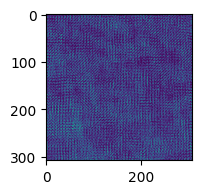

(1, 6, 308, 308)
(308, 308)


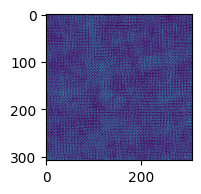

(1, 6, 308, 308)
(308, 308)


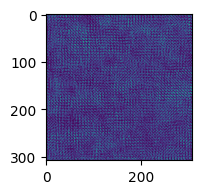

(1, 6, 308, 308)
(308, 308)


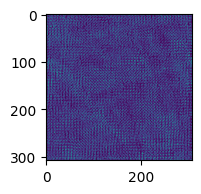

(1, 6, 308, 308)
(308, 308)


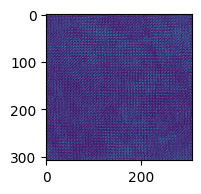

(1, 6, 308, 308)
(308, 308)


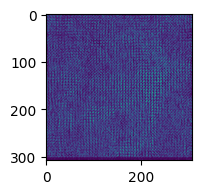

(1, 6, 308, 308)
(308, 308)


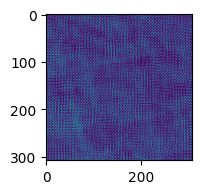

(1, 6, 308, 308)
(308, 308)


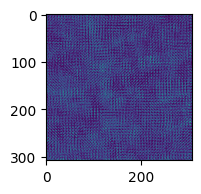

(1, 6, 308, 308)
(308, 308)


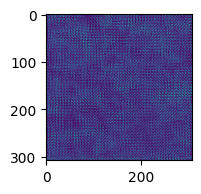

(1, 6, 308, 308)
(308, 308)


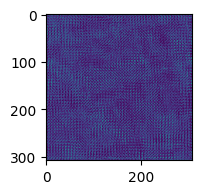

(1, 6, 308, 308)
(308, 308)


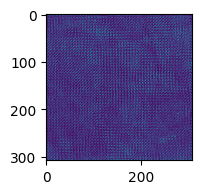

(1, 6, 308, 308)
(308, 308)


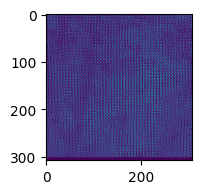

(1, 6, 308, 308)
(308, 308)


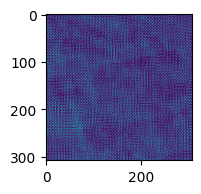

(1, 6, 308, 308)
(308, 308)


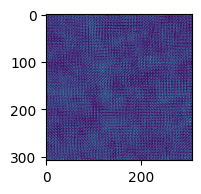

(1, 6, 308, 308)
(308, 308)


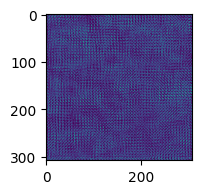

(1, 6, 308, 308)
(308, 308)


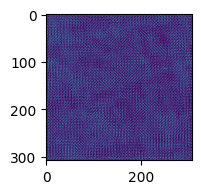

(1, 6, 308, 308)
(308, 308)


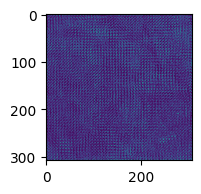

(1, 6, 308, 308)
(308, 308)


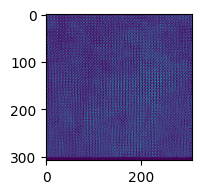

(1, 6, 308, 308)
(308, 308)


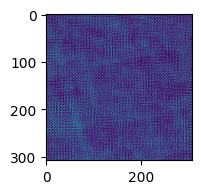

(1, 6, 308, 308)
(308, 308)


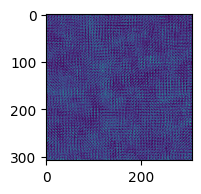

(1, 6, 308, 308)
(308, 308)


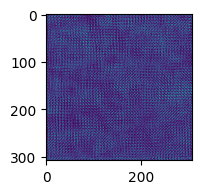

(1, 6, 308, 308)
(308, 308)


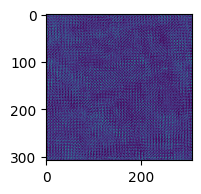

(1, 6, 308, 308)
(308, 308)


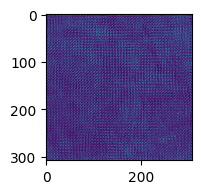

(1, 6, 308, 308)
(308, 308)


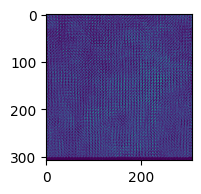

(1, 6, 308, 308)
(308, 308)


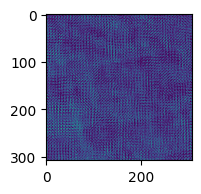

(1, 6, 308, 308)
(308, 308)


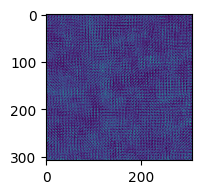

(1, 6, 308, 308)
(308, 308)


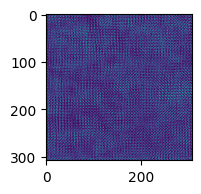

(1, 6, 308, 308)
(308, 308)


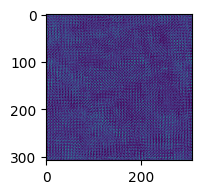

(1, 6, 308, 308)
(308, 308)


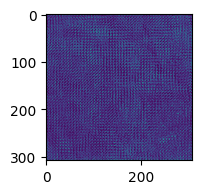

(1, 6, 308, 308)
(308, 308)


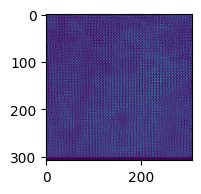

(1, 6, 308, 308)
(308, 308)


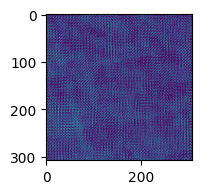

(1, 6, 308, 308)
(308, 308)


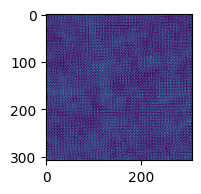

(1, 6, 308, 308)
(308, 308)


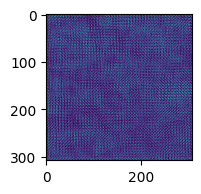

(1, 6, 308, 308)
(308, 308)


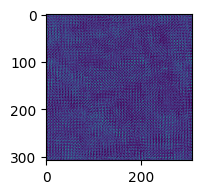

(1, 6, 308, 308)
(308, 308)


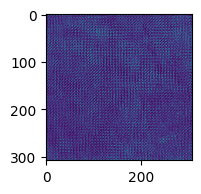

(1, 6, 308, 308)
(308, 308)


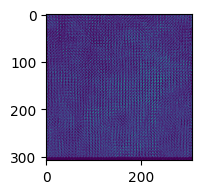

(1, 6, 308, 308)
(308, 308)


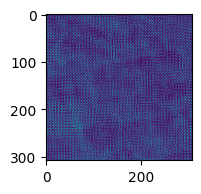

(1, 6, 308, 308)
(308, 308)


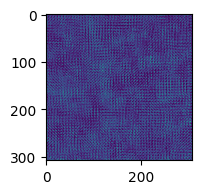

(1, 6, 308, 308)
(308, 308)


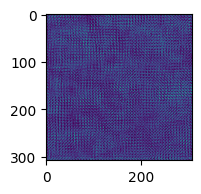

(1, 6, 308, 308)
(308, 308)


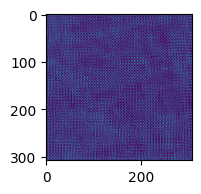

(1, 6, 308, 308)
(308, 308)


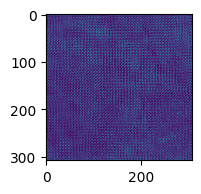

(1, 6, 308, 308)
(308, 308)


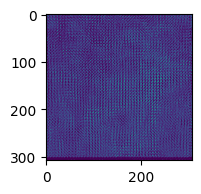

(1, 6, 308, 308)
(308, 308)


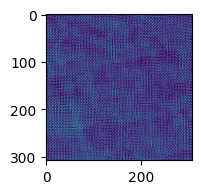

(1, 6, 308, 308)
(308, 308)


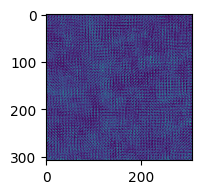

(1, 6, 308, 308)
(308, 308)


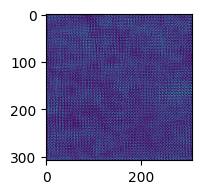

(1, 6, 308, 308)
(308, 308)


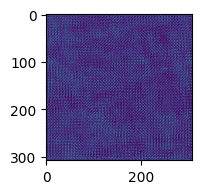

(1, 6, 308, 308)
(308, 308)


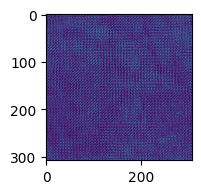

(1, 6, 308, 308)
(308, 308)


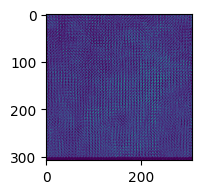

(1, 6, 308, 308)
(308, 308)


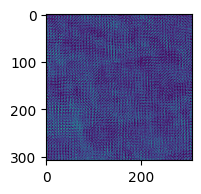

(1, 6, 308, 308)
(308, 308)


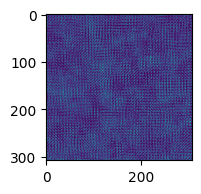

(1, 6, 308, 308)
(308, 308)


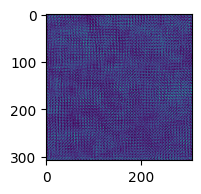

(1, 6, 308, 308)
(308, 308)


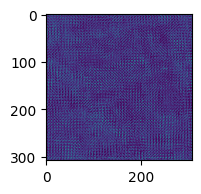

(1, 6, 308, 308)
(308, 308)


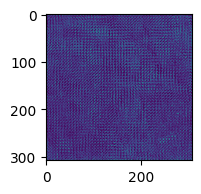

(1, 6, 308, 308)
(308, 308)


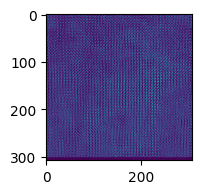

(1, 6, 308, 308)
(308, 308)


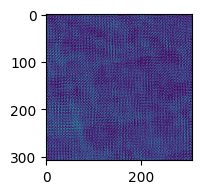

(1, 6, 308, 308)
(308, 308)


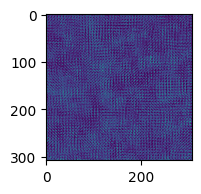

(1, 6, 308, 308)
(308, 308)


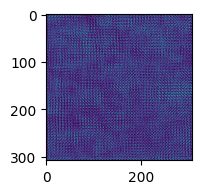

(1, 6, 308, 308)
(308, 308)


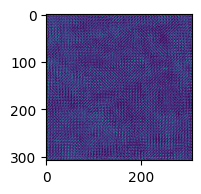

(1, 6, 308, 308)
(308, 308)


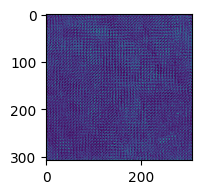

(1, 6, 308, 308)
(308, 308)


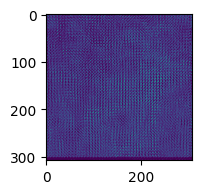

(1, 6, 308, 308)
(308, 308)


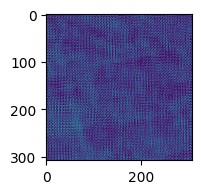

(1, 6, 308, 308)
(308, 308)


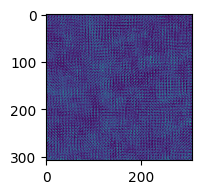

(1, 6, 308, 308)
(308, 308)


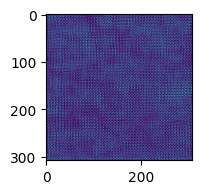

(1, 6, 308, 308)
(308, 308)


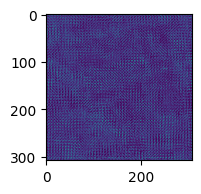

(1, 6, 308, 308)
(308, 308)


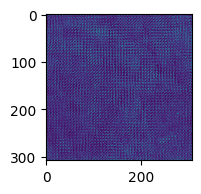

(1, 6, 308, 308)
(308, 308)


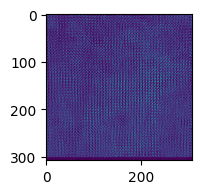

(1, 6, 308, 308)
(308, 308)


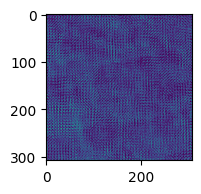

(1, 6, 308, 308)
(308, 308)


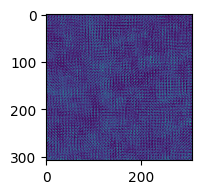

(1, 6, 308, 308)
(308, 308)


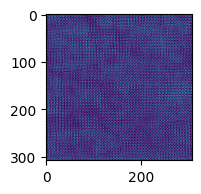

(1, 6, 308, 308)
(308, 308)


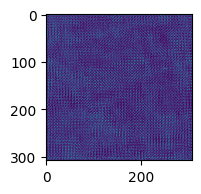

(1, 6, 308, 308)
(308, 308)


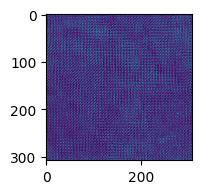

(1, 6, 308, 308)
(308, 308)


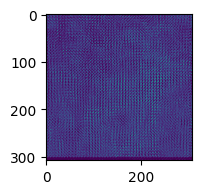

(1, 6, 308, 308)
(308, 308)


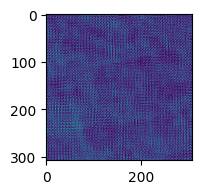

(1, 6, 308, 308)
(308, 308)


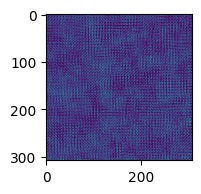

(1, 6, 308, 308)
(308, 308)


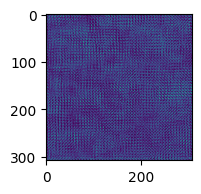

(1, 6, 308, 308)
(308, 308)


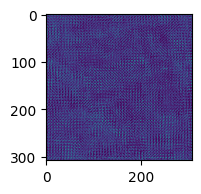

(1, 6, 308, 308)
(308, 308)


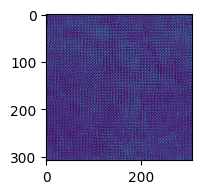

(1, 6, 308, 308)
(308, 308)


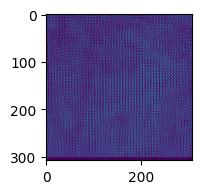

(1, 6, 308, 308)
(308, 308)


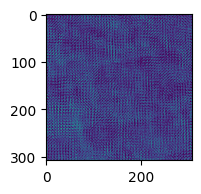

(1, 6, 308, 308)
(308, 308)


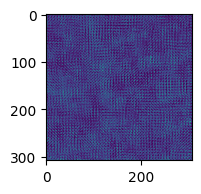

(1, 6, 308, 308)
(308, 308)


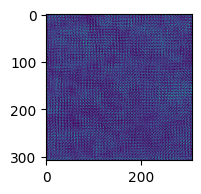

(1, 6, 308, 308)
(308, 308)


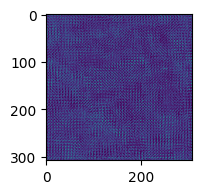

(1, 6, 308, 308)
(308, 308)


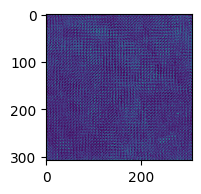

(1, 6, 308, 308)
(308, 308)


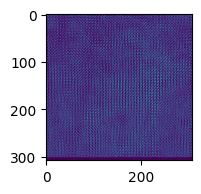

(1, 6, 308, 308)
(308, 308)


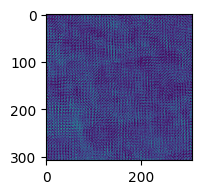

(1, 6, 308, 308)
(308, 308)


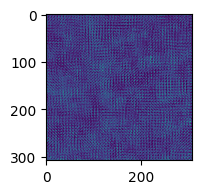

(1, 6, 308, 308)
(308, 308)


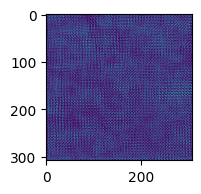

(1, 6, 308, 308)
(308, 308)


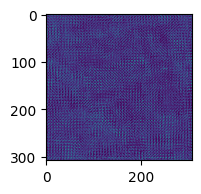

(1, 6, 308, 308)
(308, 308)


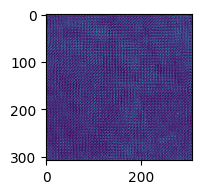

(1, 6, 308, 308)
(308, 308)


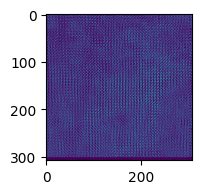

In [23]:
Undip_model = Undip_net_paper()
# the training command
model, losses_train, losses_abundance = train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y), lr=0.001, epochs=3000)

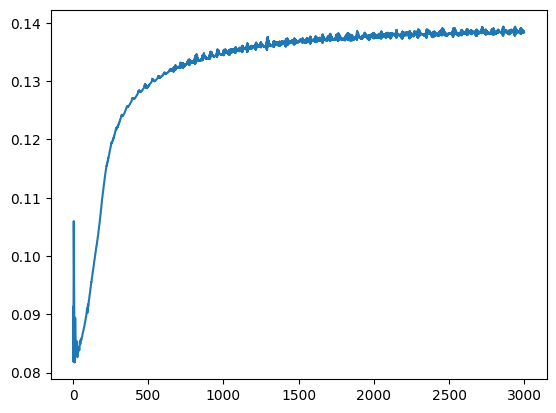

In [17]:
plt.plot(losses_abundance)

<ipython-input-24-1d7f8af8b421>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model, losses_train, losses_abundance = train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y), lr=0.001, epochs=300)


(1, 6, 308, 308)
(308, 308)


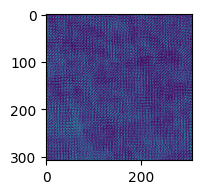

(1, 6, 308, 308)
(308, 308)


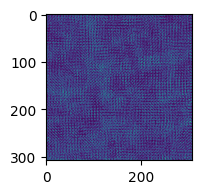

(1, 6, 308, 308)
(308, 308)


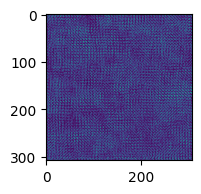

(1, 6, 308, 308)
(308, 308)


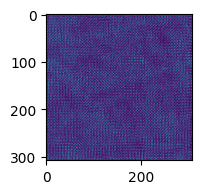

(1, 6, 308, 308)
(308, 308)


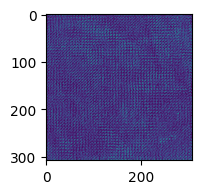

(1, 6, 308, 308)
(308, 308)


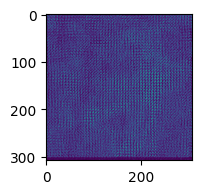

In [24]:
Undip_model = Undip_net_paper()
# the training command
model, losses_train, losses_abundance = train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y), lr=0.001, epochs=300)

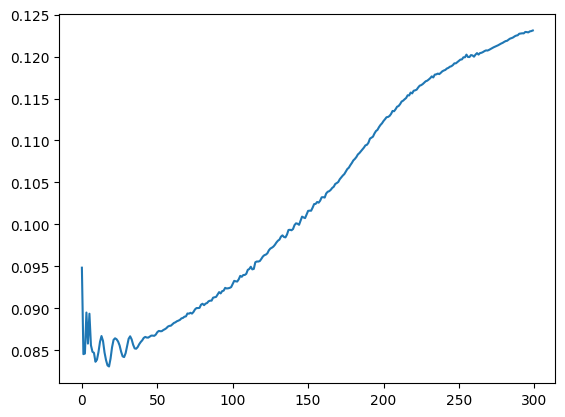

In [25]:
plt.plot(losses_abundance)

<ipython-input-28-ba867b0cba58>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model, losses_train, losses_abundance = train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y), lr=0.01, epochs=300)


(1, 6, 308, 308)
(308, 308)


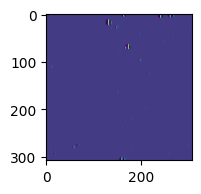

(1, 6, 308, 308)
(308, 308)


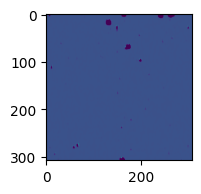

(1, 6, 308, 308)
(308, 308)


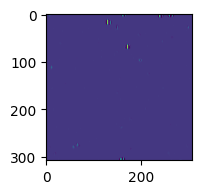

(1, 6, 308, 308)
(308, 308)


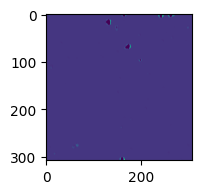

(1, 6, 308, 308)
(308, 308)


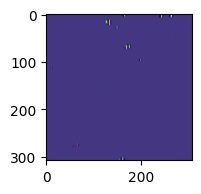

(1, 6, 308, 308)
(308, 308)


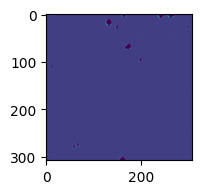

In [28]:
Undip_model = Undip_net_paper()
# the training command
model, losses_train, losses_abundance = train(Undip_model,torch.tensor(A),torch.tensor(E),torch.tensor(Y), lr=0.01, epochs=300)

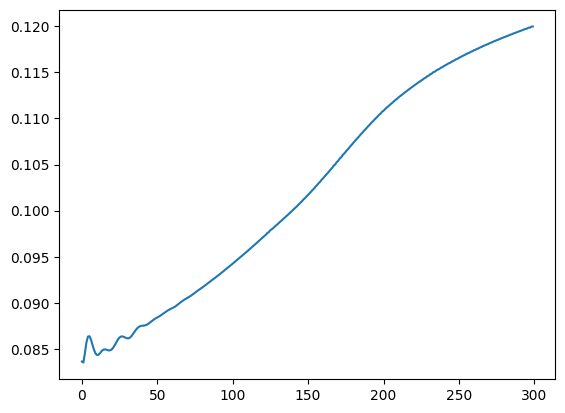

In [27]:
plt.plot(losses_abundance)